In [1]:
import sys
import time
import os
from collections import defaultdict
import numpy as np
import jax.numpy as jnp
import vedo
from vedo import Volume, show
import vedo.plotter  # https://vedo.embl.es/docs/vedo/plotter.html#Plotter
from vedo.colors import color_map
vedo.settings.default_backend = "vtk"
# vedo.settings.renderer_frame_width = 1.
# vedo.settings.use_parallel_projection = True

import matplotlib.pyplot as plt
# from matplotlib import colormaps
# list(colormaps)
from matplotlib.colors import LinearSegmentedColormap

from ipywidgets import interact

from jax import jit, vmap, value_and_grad, nn
import jax
import jax.numpy as jnp
from jax.numpy.fft import fft2, ifft2, fftshift, fftfreq
from jaxdf import FourierSeries 
from jaxdf.operators import compose
from jwave.geometry import Domain, Medium, TimeAxis, circ_mask
from jwave.acoustics import simulate_wave_propagation

from v_system.VSystemGenerator import VSystemGenerator
import scipy.ndimage
import vis
import reconstruct as r
import generate_data as gd
import util as u
import reconstruct as r
from PADataset import PADataset
from flax import linen as nn

@u.timer
def reconstruct(func_recon, func_step, **kwargs):
    return func_recon(func_step=func_step, **kwargs)

key = jax.random.PRNGKey(68002)

dataset=PADataset()
data = dataset[0]
mu = data['mu']
c = data['c']
sensors = data['sensors']
ATT_masks = data['ATT_masks']
P_0 = data['P_0']
P_data = data['P_data']
angles = data['angles']
P_data_noisy = data['P_data_noisy']

num_it=100
num_illum = 4


# Iterative reconstruction figure

In [2]:
# Display iterations of a reconstruction.

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import matplotlib.ticker as ticker
import util as u
import reconstruct as r 
from PADataset import PADataset

save_path = '../../Report/figures/'
num_recon_images = 5
dpi = 1000
title_fontsize = 8
file_index = 0


def compute_min_max(arrays):
    """Compute the global min and max values across all arrays."""
    stacked_arrays = np.stack(arrays)
    return [stacked_arrays.min(), stacked_arrays.max()]

   
def plot_recon(recon, run_time, num_recon_images=num_recon_images, num_illum=num_illum, num_it=num_it):
    num_it = len(recon['mu_rs'])
    grid_x = num_recon_images + 3
    fig = plt.figure(figsize=(14,4))  
    # fig = plt.figure(figsize=((num_recon_images + 2) * 2, 4))  
    gs = gridspec.GridSpec(2, grid_x, width_ratios=[1] * num_recon_images + [0.1, 1, 0.1])
    gs[0,4].wspace=10
    ax = [[fig.add_subplot(gs[i, j]) for j in range(grid_x)] for i in range(2)]

    indices = np.linspace(1, num_it - 1, num_recon_images, dtype=int)

    mu_rs = recon["mu_rs"]
    mu_rs = np.array(mu_rs)[indices]
    c_rs = recon["c_rs"]
    c_rs = np.array(c_rs)[indices]
    
    min_max_mu = compute_min_max(mu_rs)
    min_max_c = compute_min_max(c_rs)
    
    for i, idx in enumerate(indices):
        im_mu = ax[0][i].imshow(recon['mu_rs'][idx] , vmin=min_max_mu[0], vmax=min_max_mu[1], aspect="equal")
        im_c = ax[1][i].imshow(recon['c_rs'][idx], vmin=min_max_c[0], vmax=min_max_c[1], aspect="equal")
        
        ax[0][i].axis("off")
        ax[1][i].axis("off")

        ax[1][i].text(fontsize=8, x=5, y=135.,va='top', ha='left', s=f"Iteration: {idx+1}")# \nmu loss: {loss[num_illums[i]]['mu'][-1]:.2f} \nc loss: {loss[num_illums[i]]['c'][-1]:.2f} \nRun time: {loss[num_illums[i]]['run_time']:.1f}s")
    
    ax[1][i].text(fontsize=8, x=5, y=135.,va='top', ha='left', s=f"\nIlluminations: {num_illum}\nRun time: {run_time:.1f}s")

    # y-axis labels
    fig.text(0.115, 0.7, 'mu_r', va='center', ha='center', rotation='vertical', fontsize=12)
    fig.text(0.115, 0.3, 'c_r', va='center', ha='center', rotation='vertical', fontsize=12)

    pos_im_r0 = ax[0][0].get_position()
    pos_im_r1 = ax[1][0].get_position()

    
    i_cb = num_recon_images
    plt.colorbar(im_mu, cax=ax[0][i_cb])
    ax[0][i_cb].tick_params(labelsize=7)
    ax[0][i_cb].yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    pos = ax[0][i_cb].get_position()
    ax[0][i_cb].set_position([pos.x0-.01, pos_im_r0.y0, pos.width, pos_im_r0.height])    

    plt.colorbar(im_c, cax=ax[1][i_cb])
    ax[1][i_cb].tick_params(labelsize=7)
    pos = ax[1][i_cb].get_position()
    ax[1][i_cb].set_position([pos.x0-.01, pos_im_r1.y0, pos.width, pos_im_r1.height])



    i_gt = num_recon_images + 1
    im_mu_gt = ax[0][i_gt].imshow(mu, aspect="equal")
    ax[0][i_gt].axis("off")
    pos = ax[0][i_gt].get_position()
    ax[0][i_gt].set_position([pos.x0 + 0.01, pos.y0, pos.width, pos.height])

    plt.colorbar(im_mu_gt, cax=ax[0][i_gt+1])
    ax[0][i_gt+1].tick_params(labelsize=7)
    ax[1][i_cb].yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    pos = ax[0][i_gt+1].get_position()
    ax[0][i_gt+1].set_position([pos.x0, pos_im_r0.y0, pos.width, pos_im_r0.height])

    im_c_gt = ax[1][i_gt].imshow(c, aspect="equal")
    ax[1][i_gt].axis("off")
    pos = ax[1][i_gt].get_position()
    ax[1][i_gt].set_position([pos.x0 + 0.01, pos.y0, pos.width, pos.height])

    plt.colorbar(im_c_gt, cax=ax[1][i_gt+1])
    ax[1][i_gt+1].tick_params(labelsize=7)
    pos = ax[1][i_gt+1].get_position()
    ax[1][i_gt+1].set_position([pos.x0, pos_im_r1.y0, pos.width, pos_im_r1.height])

    ax[1][i_gt].text(s=f"Ground truth", x=64, y=135.,va='top', ha='center')

    plt.show()
    return fig

def plot_losses(losses):
    fig, ax = plt.subplots(1, 3, figsize=(7, 1.5))

    ax[0].plot(np.log10(losses['mu']), label='mu')
    ax[1].plot(np.log10(losses['c']), label='c')
    ax[2].plot(np.log10(losses['data']), label='data')

    ax[0].set_ylabel(r"$log_{10}(loss\ mu)$", fontsize=title_fontsize)
    ax[0].set_xlabel("Iteration", fontsize=title_fontsize)
    ax[1].set_ylabel(r"$log_{10}(loss\ c)$", fontsize=title_fontsize)
    ax[1].set_xlabel("Iteration", fontsize=title_fontsize)
    ax[2].set_ylabel(r"$log_{10}(loss\ data)$", fontsize=title_fontsize)
    ax[2].set_xlabel("Iteration", fontsize=title_fontsize)

    plt.subplots_adjust(wspace=0.75)
    plt.show()
    return fig


# plot_losses(loss_recon, run_time)
# figure = plot_recon(recon, run_time)#, num_it=num_it)
# figure

### Single Optimizer

illumination angles: [  0.  90. 180. 270.]
Finished 'reconstruct' in 5.2685 secs


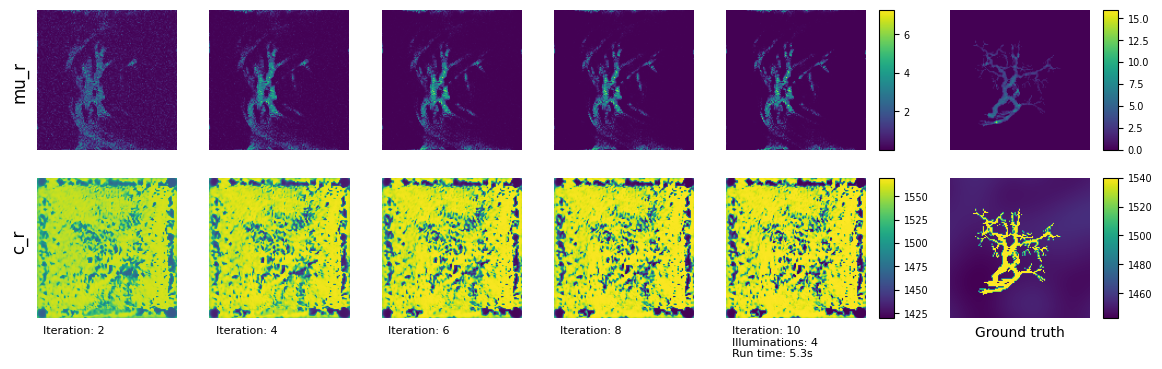

FigureCanvasAgg is non-interactive, and thus cannot be shown


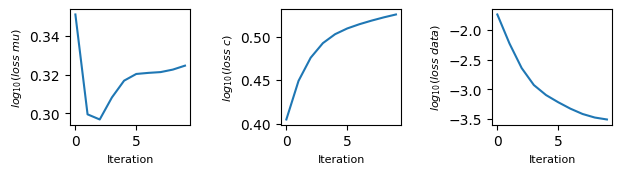

FigureCanvasAgg is non-interactive, and thus cannot be shown


In [3]:
num_it = 10
num_illum = 4

key, subkey = jax.random.split(key)

(loss_recon, recon), run_time = reconstruct(
    func_recon=r.recon_1opt,
    func_step=r.recon_step,
    file_index=file_index,
    lr=1.,
    num_illum=num_illum,
    num_it=num_it,
    key=subkey,
    dataset=dataset,
    # func_step_kwargs={"r_mu": 0, "r_c": 0},
)

name = "recon_nodupe"

figure = plot_recon(recon, run_time)
figure.savefig(save_path+f"{name}.pdf", bbox_inches='tight', format='pdf', dpi=dpi)
figure.show()
fig_loss = plot_losses(loss_recon)
fig_loss.savefig(save_path+f"{name}_loss.pdf", bbox_inches='tight', format='pdf', dpi=dpi//2)
fig_loss.show()

illumination angles: [  0.  90. 180. 270.]
Finished 'reconstruct' in 4.8193 secs


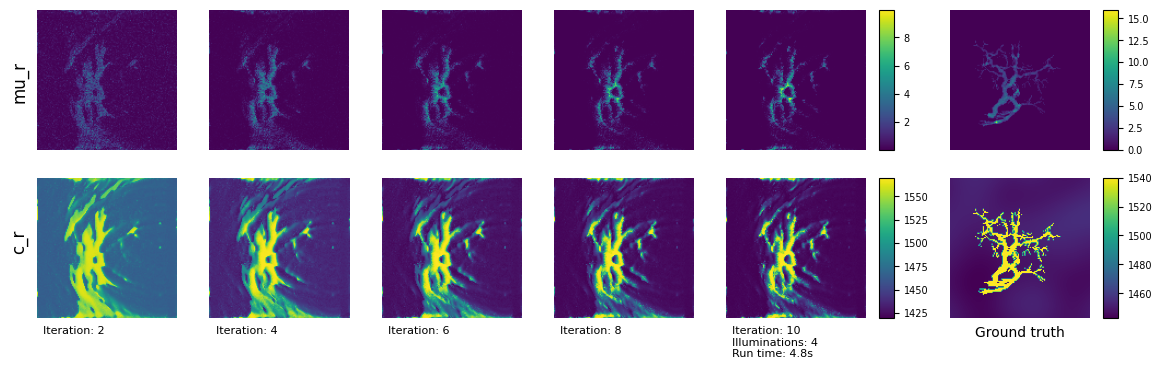

FigureCanvasAgg is non-interactive, and thus cannot be shown


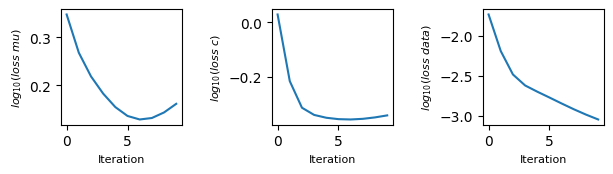

FigureCanvasAgg is non-interactive, and thus cannot be shown


In [6]:
num_it = 10
num_illum = 4

key, subkey = jax.random.split(key)

(loss_recon, recon), run_time = reconstruct(
    func_recon=r.recon_1opt,
    func_step=r.recon_step,
    file_index=file_index,
    lr=1.,
    num_illum=num_illum,
    num_it=num_it,
    key=subkey,
    dataset=dataset,
    # func_step_kwargs={"r_mu": 0, "r_c": 0},
)

name = "recon_dupe"

figure = plot_recon(recon, run_time)
figure.savefig(save_path+f"{name}.pdf", bbox_inches='tight', format='pdf', dpi=dpi)
figure.show()
fig_loss = plot_losses(loss_recon)
fig_loss.savefig(save_path+f"{name}_loss.pdf", bbox_inches='tight', format='pdf', dpi=dpi//2)
fig_loss.show()

### 2 Optimizers

illumination angles: [  0.  90. 180. 270.]
Finished 'reconstruct' in 58.2535 secs


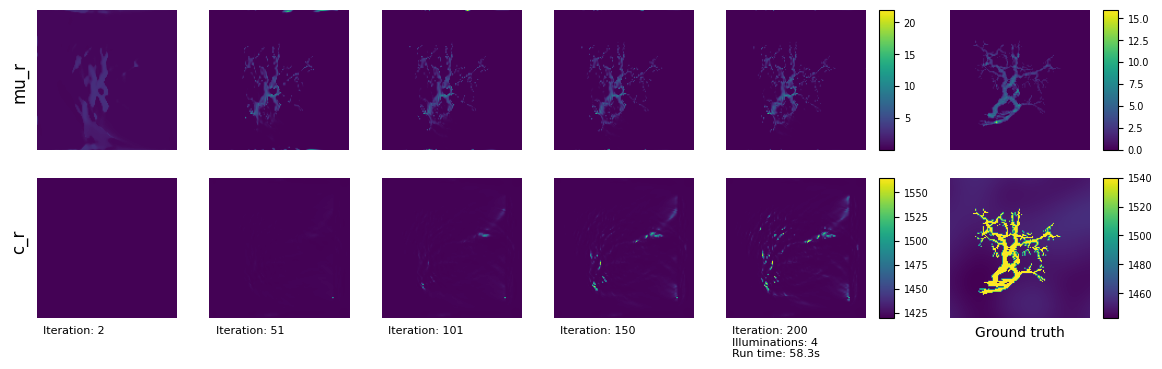

FigureCanvasAgg is non-interactive, and thus cannot be shown


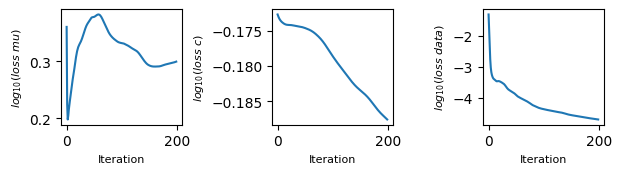

FigureCanvasAgg is non-interactive, and thus cannot be shown


In [6]:
num_it = 200
num_illum = 4

key, subkey = jax.random.split(key)

(loss_recon, recon), run_time = reconstruct(
    func_recon=r.recon_2opt,
    func_step=r.recon_step,
    file_index=file_index,
    lr=[1.,.1],
    num_illum=num_illum,
    num_it=num_it,
    key=subkey,
    dataset=dataset,
    # func_step_kwargs={"r_mu": 0, "r_c": 0},
)


name = "recon_2opt_nodupe"

figure = plot_recon(recon, run_time)
figure.savefig(save_path+f"{name}.pdf", bbox_inches='tight', format='pdf', dpi=dpi)
figure.show()
fig_loss = plot_losses(loss_recon)
fig_loss.savefig(save_path+f"{name}_loss.pdf", bbox_inches='tight', format='pdf', dpi=dpi//2)
fig_loss.show()

illumination angles: [  0.  90. 180. 270.]
Finished 'reconstruct' in 4.6273 secs


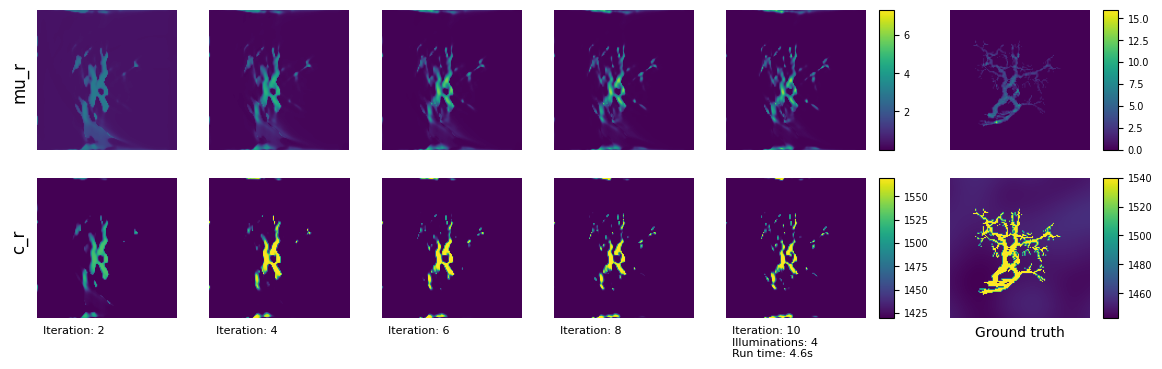

FigureCanvasAgg is non-interactive, and thus cannot be shown


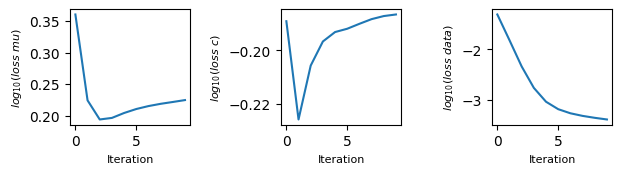

FigureCanvasAgg is non-interactive, and thus cannot be shown


In [11]:
num_it = 10
num_illum = 4

key, subkey = jax.random.split(key)

(loss_recon, recon), run_time = reconstruct(
    func_recon=r.recon_2opt,
    func_step=r.recon_step,
    file_index=file_index,
    lr=[1.,3.],
    num_illum=num_illum,
    num_it=num_it,
    key=subkey,
    dataset=dataset,
    # func_step_kwargs={"r_mu": 0, "r_c": 0},
)


name = "recon_2opt_dupe"

figure = plot_recon(recon, run_time)
figure.savefig(save_path+f"{name}.pdf", bbox_inches='tight', format='pdf', dpi=dpi)
figure.show()
fig_loss = plot_losses(loss_recon)
fig_loss.savefig(save_path+f"{name}_loss.pdf", bbox_inches='tight', format='pdf', dpi=dpi//2)
fig_loss.show()

---

In [ ]:
num_it = 10
num_illum = 4

key, subkey = jax.random.split(key)

(loss_recon, recon), run_time = reconstruct(
    func_recon=r.recon_2opt_r,
    func_step=r.recon_step,
    file_index=file_index,
    lr=[1.,.3],
    num_illum=num_illum,
    num_it=num_it,
    key=subkey,
    dataset=dataset,
    # func_step_kwargs={"r_mu": 0, "r_c": 0},
)


name = "recon_2opt_dupe8"

figure = plot_recon(recon, run_time)
# figure.savefig(save_path+f"{name}.pdf", bbox_inches='tight', format='pdf', dpi=dpi)
figure.show()
fig_loss = plot_losses(loss_recon)
# fig_loss.savefig(save_path+f"{name}_loss.pdf", bbox_inches='tight', format='pdf', dpi=dpi//2)
fig_loss.show()

---

illumination angles: [  0.  90. 180. 270.]
Finished 'reconstruct' in 143.2979 secs


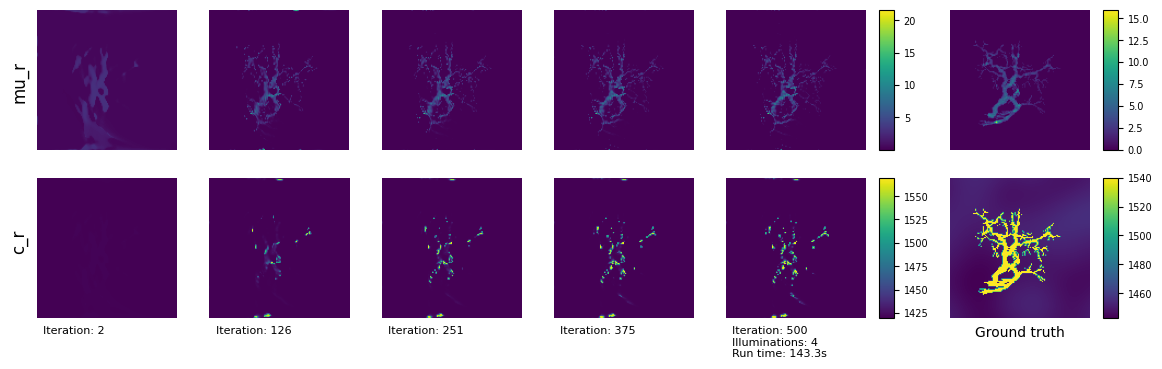

FigureCanvasAgg is non-interactive, and thus cannot be shown


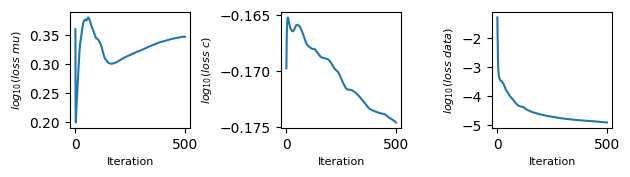

FigureCanvasAgg is non-interactive, and thus cannot be shown


In [7]:
num_it = 500
num_illum = 4

key, subkey = jax.random.split(key)

(loss_recon, recon), run_time = reconstruct(
    func_recon=r.recon_2opt,
    func_step=r.recon_step,
    file_index=file_index,
    lr=[1.,.3],
    num_illum=num_illum,
    num_it=num_it,
    key=subkey,
    dataset=dataset,
    # func_step_kwargs={"r_mu": 0, "r_c": 0},
)


name = "recon_2opt_dupe8"

figure = plot_recon(recon, run_time)
# figure.savefig(save_path+f"{name}.pdf", bbox_inches='tight', format='pdf', dpi=dpi)
figure.show()
fig_loss = plot_losses(loss_recon)
# fig_loss.savefig(save_path+f"{name}_loss.pdf", bbox_inches='tight', format='pdf', dpi=dpi//2)
fig_loss.show()

illumination angles: [  0.        86.399994 172.79999  259.19998  352.8     ]
File 0 
Iter	Loss_data	Loss_mu		Loss_c		Loss_sum_mu_c
0	0.064987	2.715958	0.869695	3.585654
2	0.023700	2.215267	0.636206	2.851473
4	0.012939	1.970850	0.495601	2.466451
6	0.008540	1.811586	0.472034	2.283620
9	0.005326	1.680051	0.495270	2.175322
Finished 'reconstruct' in 5.5805 secs


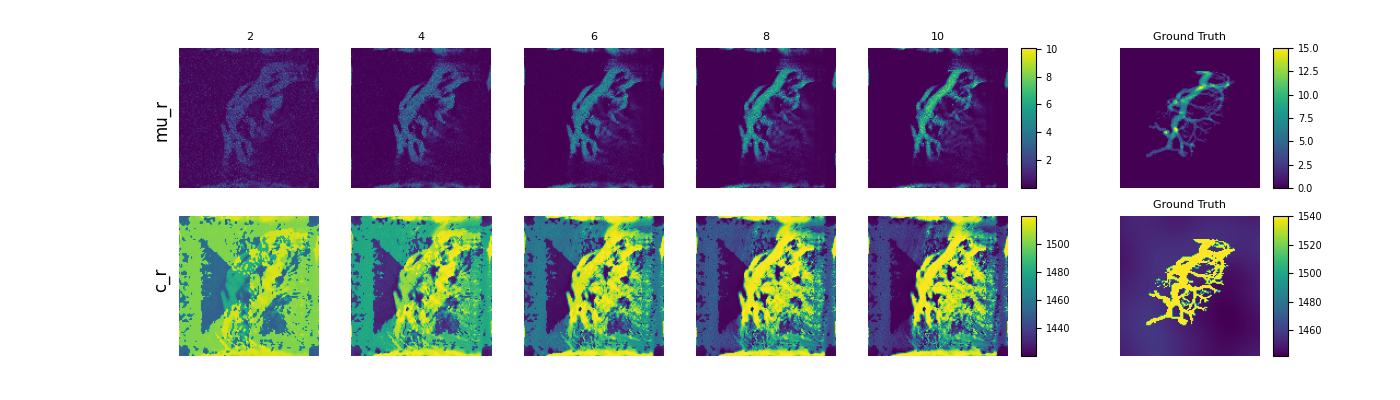

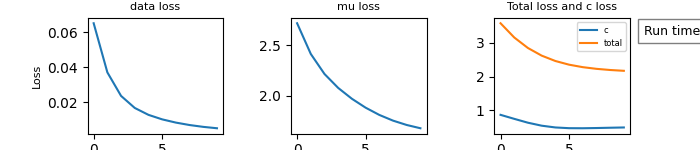

In [ ]:
(losses, recon), run_time = reconstruct(r.recon_2opt, r.recon_step_ATr_2opt, lr=[1.,1.], num_illum=num_illum, num_it=num_it)
figure = plot_recon(recon=recon)#, num_it=num_it)
figure.savefig(save_path+"recon_step_ATr_2opt.pdf", bbox_inches='tight', format='pdf', dpi=dpi)
fig_loss = plot_losses(losses, run_time)
fig_loss.savefig(save_path+"recon_step_ATr_2opt_losses.pdf", bbox_inches='tight', format='pdf', dpi=dpi//2)

### Pre-parameterization

illumination angles: [0.]
File 0 
Iter	Loss_data	Loss_mu		Loss_c		Loss_sum_mu_c
0	0.086781	2.773344	0.819968	3.593312
52	0.000289	1.488126	0.561155	2.049281
105	0.000122	1.390740	0.550141	1.940881
158	0.000078	1.341652	0.546689	1.888341
211	0.000057	1.300784	0.544518	1.845302
Finished 'reconstruct_2' in 33.8929 secs


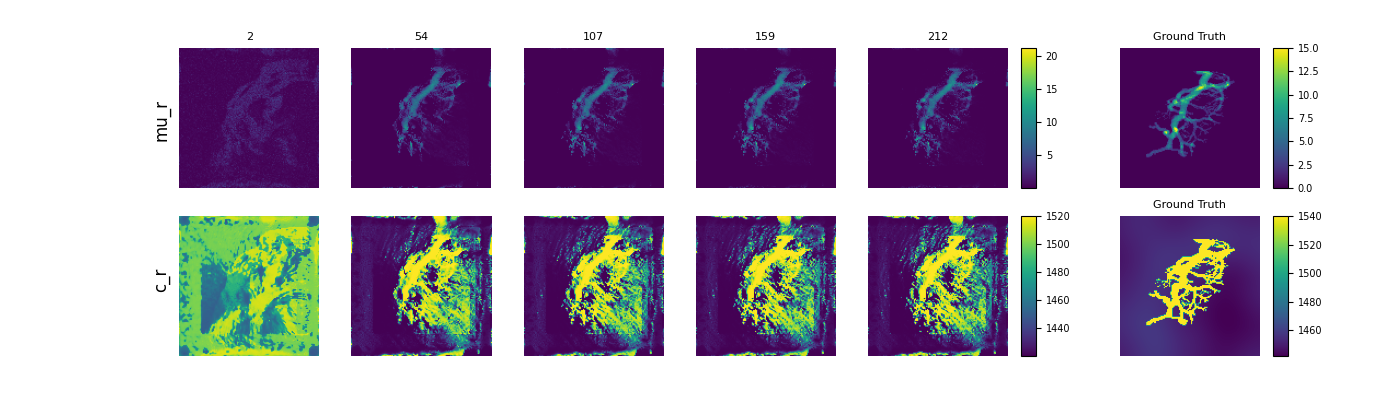

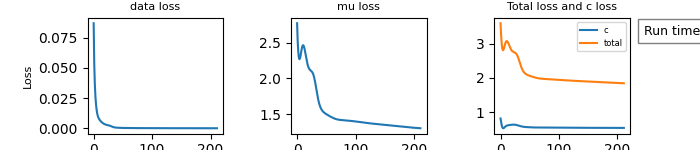

In [ ]:
num_it=212
(losses, recon), run_time = reconstruct_2(r.recon_step_full, lr=[1.,1.], num_illum=1, num_it=num_it)
figure = plot_recon(0, recon=recon, losses=losses, run_time=run_time, num_recon_images=num_recon_images, num_it=num_it)
# figure.savefig(save_path+"recon_step_full.pdf", bbox_inches='tight', format='pdf', dpi=dpi)
fig_loss = plot_losses(losses, run_time)
# fig_loss.savefig(save_path+"recon_step_full_losses.pdf", bbox_inches='tight', format='pdf', dpi=dpi//2)

File 0 
Iter	Loss_data	Loss_mu		Loss_c		Loss_sum_mu_c
0	0.054356	2.712943	0.868375	3.581318
0	0.054356	2.712943	0.868375	3.581318
0	0.054356	2.712943	0.868375	3.581318
0	0.054356	2.712943	0.868375	3.581318
1	0.029323	2.409480	0.751826	3.161306
Finished 'reconstruct' in 6.1814 secs


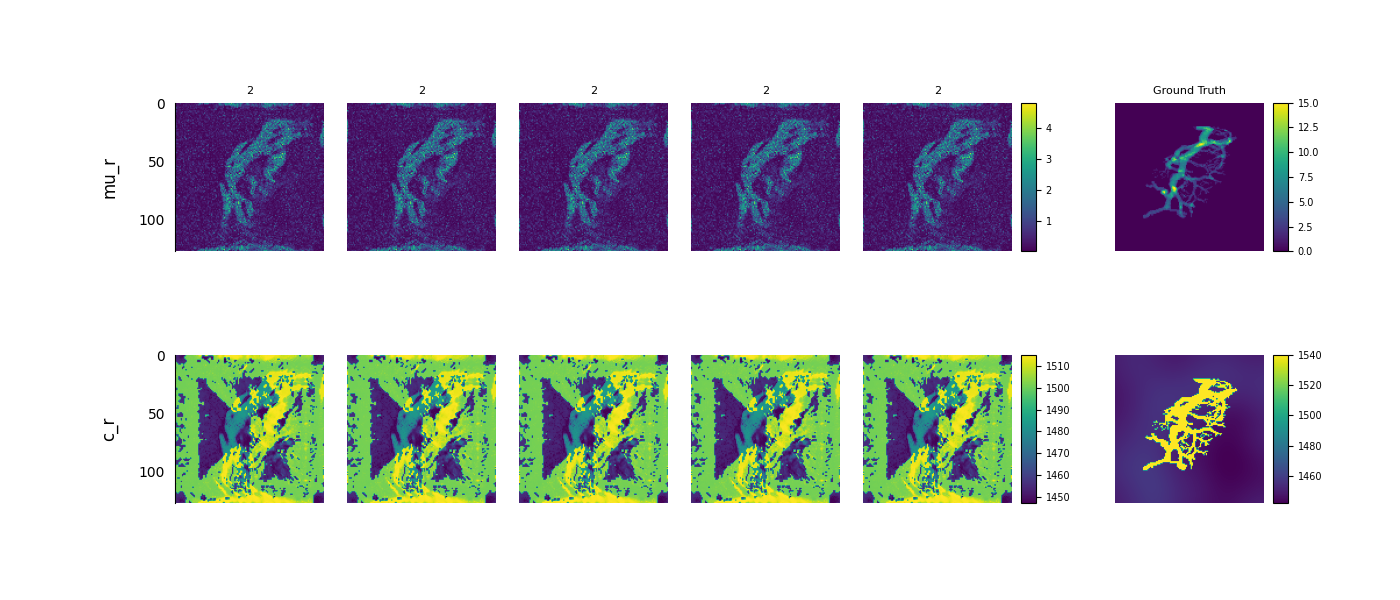

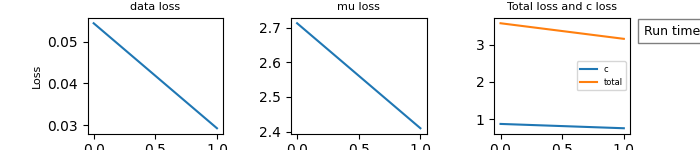

In [ ]:
num_it=2
(losses, recon), run_time = reconstruct(r.recon_step_ATrmu_p_opt2_p, lr=[1.,1.], num_it=num_it)
figure = plot_recon(0, recon=recon, losses=losses, run_time=run_time, num_recon_images=num_recon_images, num_it=num_it)
# figure.savefig(save_path+"recon_step_ATrmu_p_opt2_p.pdf", bbox_inches='tight', format='pdf', dpi=dpi)
fig_loss = plot_losses(losses, run_time)
# fig_loss.savefig(save_path+"recon_step_ATrmu_p_opt2_p_losses.pdf", bbox_inches='tight', format='pdf', dpi=dpi//2)

File 0 
Iter	Loss_data	Loss_mu		Loss_c		Loss_sum_mu_c
0	0.047371	2.761351	0.892957	3.654308
24	0.000438	1.599838	0.408666	2.008504
49	0.000111	1.523825	0.378239	1.902065
74	0.000068	1.433025	0.357964	1.790989
99	0.000040	1.424621	0.343760	1.768380
Finished 'reconstruct' in 59.7024 secs


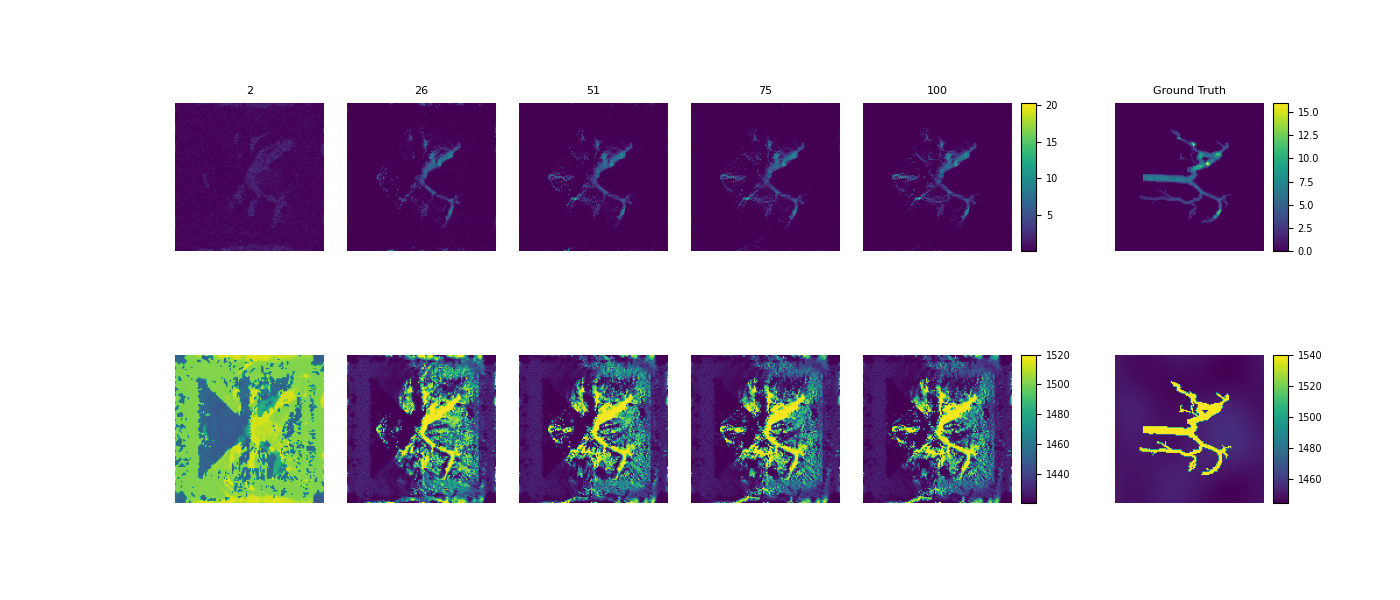

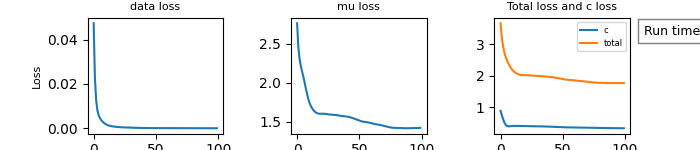

In [ ]:
num_it=100
(losses, recon), run_time = reconstruct(r.recon_step_ATrmu_p_opt2_p, lr=[1.,1.], num_it=num_it)
figure = plot_recon(0, recon=recon, losses=losses, run_time=run_time, num_recon_images=num_recon_images, num_it=num_it)
figure.savefig(save_path+"recon_step_ATrmu_p_opt2_p.pdf", bbox_inches='tight', format='pdf', dpi=dpi)
fig_loss = plot_losses(losses, run_time)
fig_loss.savefig(save_path+"recon_step_ATrmu_p_opt2_p_losses.pdf", bbox_inches='tight', format='pdf', dpi=dpi//2)

File 0 
Iter	Loss_data	Loss_mu		Loss_c		Loss_sum_mu_c
0	0.047371	3.407542	0.666487	4.074029
12	0.044250	3.327730	0.680117	4.007847
24	0.041317	3.252003	0.693857	3.945860
36	0.038563	3.180180	0.707655	3.887835
49	0.035771	3.106652	0.722620	3.829272
Finished 'reconstruct' in 29.7796 secs


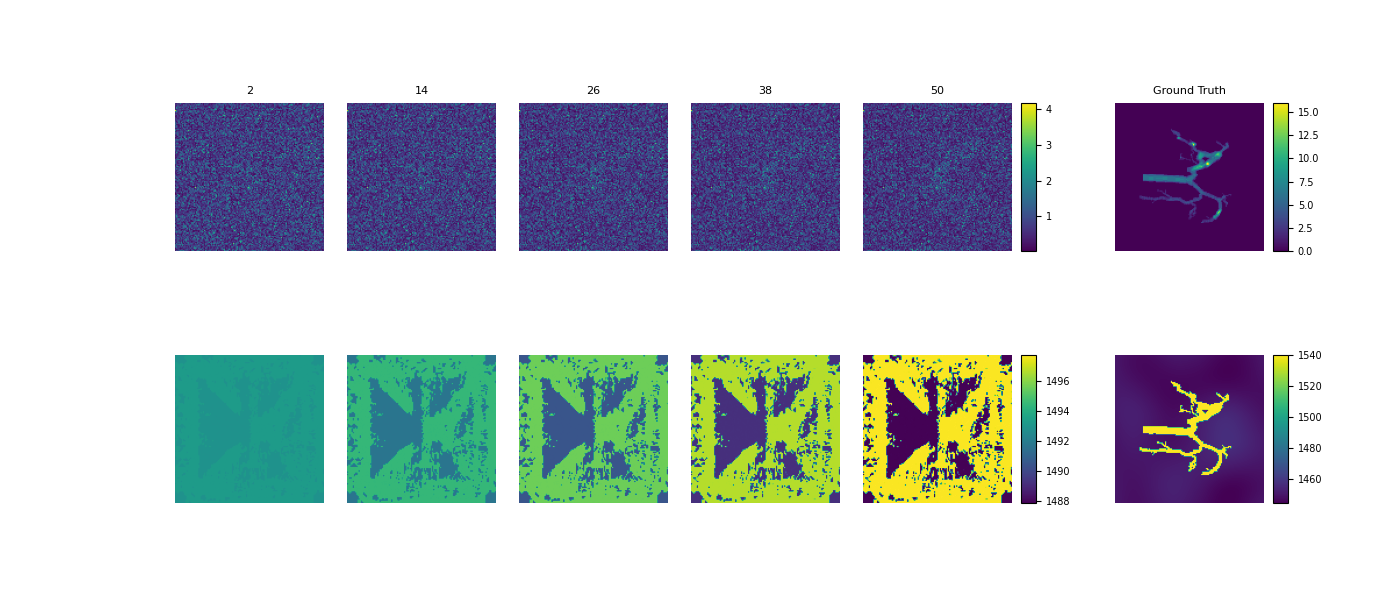

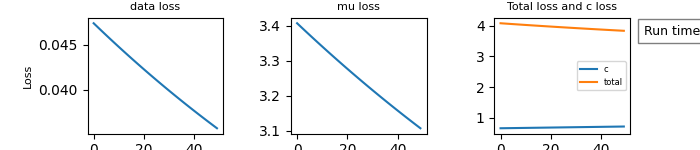

In [ ]:
num_it=50
(losses, recon), run_time = reconstruct(r.recon_step_ATrmu_p_opt1_p, lr=.005, num_it=num_it)
figure = plot_recon(0, recon=recon, losses=losses, run_time=run_time, num_recon_images=num_recon_images, num_it=num_it)
figure.savefig(save_path+"recon_step_ATrmu_p_opt1_p.pdf", bbox_inches='tight', format='pdf', dpi=dpi)
fig_loss = plot_losses(losses, run_time)
fig_loss.savefig(save_path+"recon_step_ATrmu_p_opt1_p_losses.pdf", bbox_inches='tight', format='pdf', dpi=dpi//2)

File 0 
Iter	Loss_data	Loss_mu		Loss_c		Loss_sum_mu_c
0	0.075364	0.877876	428.591400	429.469269
4	0.002153	0.671276	1480.657227	1481.328491
9	0.001346	0.775832	2962.585449	2963.361328
14	0.001730	0.863606	4622.900391	4623.764160
19	0.001860	0.845632	6928.199707	6929.045410
Finished 'reconstruct' in 11.6285 secs


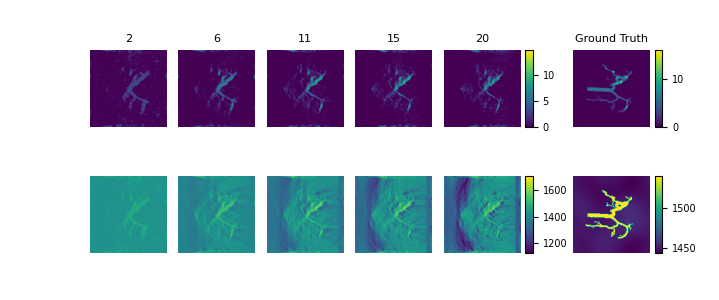

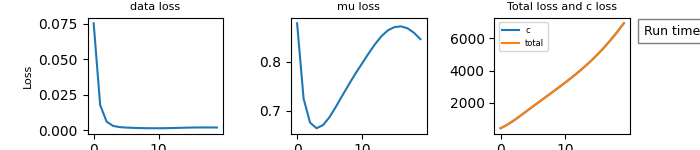

In [ ]:
num_it=20
(losses, recon), run_time = reconstruct(r.recon_step_ATrmu_opt2_norm, lr=[.9,.9], num_it=num_it)
figure = plot_recon(0, recon=recon, losses=losses, run_time=run_time, num_recon_images=num_recon_images, num_it=num_it)
figure.savefig(save_path+"recon_step_ATrmu_opt2_norm.pdf", bbox_inches='tight', format='pdf', dpi=dpi)
fig_loss = plot_losses(losses, run_time)
fig_loss.savefig(save_path+"recon_step_ATrmu_opt2_norm_losses.pdf", bbox_inches='tight', format='pdf', dpi=dpi//2)

File 0 
Iter	Loss_data	Loss_mu		Loss_c		Loss_sum_mu_c
0	0.075364	1.205567	325.255127	326.460693
2	0.027499	0.850317	325.175201	326.025513
4	0.007944	0.706907	325.246277	325.953186
6	0.003130	0.646803	325.275238	325.922028
9	0.001728	0.605673	325.284515	325.890198
Finished 'reconstruct' in 5.8503 secs


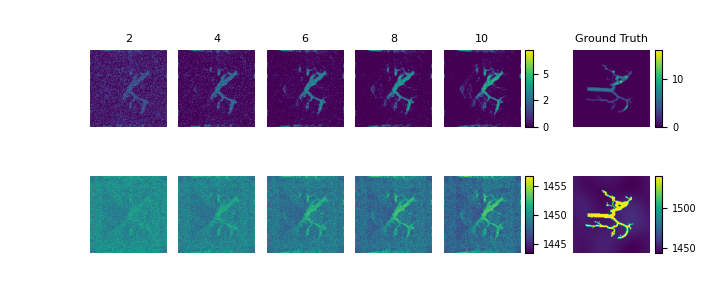

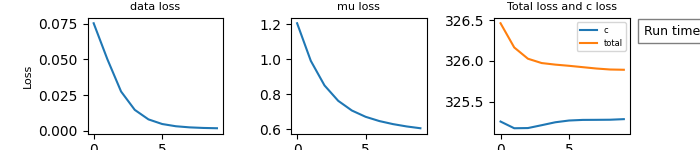

In [ ]:
(losses, recon), run_time = reconstruct(r.recon_step_ATrmu_opt2, lr=[.5,.5], num_it=10)
figure = plot_recon(0, recon, losses, run_time, num_recon_images, num_it)
figure.savefig(save_path+"recon_step_ATrmu_opt2.pdf", bbox_inches='tight', format='pdf', dpi=dpi)
fig_loss = plot_losses(losses, run_time)
fig_loss.savefig(save_path+"recon_step_ATrmu_opt2_losses.pdf", bbox_inches='tight', format='pdf', dpi=dpi//2)

File 0 
Iter	Loss_data	Loss_mu		Loss_c		Loss_sum_mu_c
0	0.075362	1.439308	327.105927	328.545227
2	0.071119	1.328491	335.452148	336.780640
4	0.058214	1.229231	348.793945	350.023163
6	0.047245	1.141437	366.640808	367.782257
9	0.034175	1.030660	400.306244	401.336914
Finished 'reconstruct' in 5.8648 secs


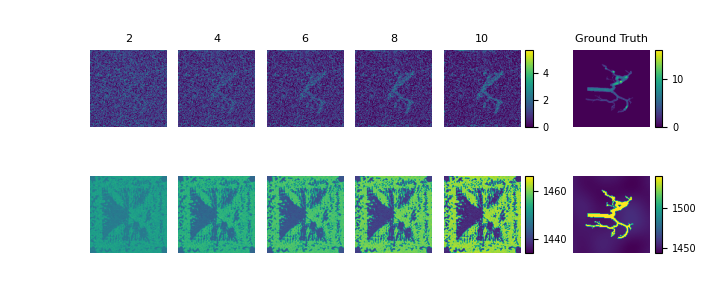

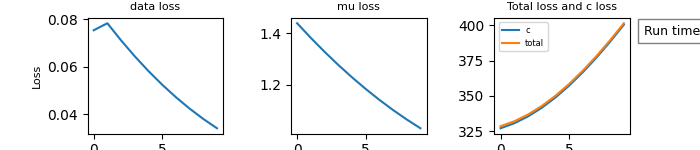

In [ ]:
(losses, recon), run_time = reconstruct(r.recon_step_ATrmu_opt1_norm, lr=.05, num_it=10)
figure = plot_recon(0, recon=recon, losses=losses, run_time=run_time, num_recon_images=num_recon_images, num_it=num_it)
figure.savefig(save_path+"recon_step_ATrmu_opt1_norm.pdf", bbox_inches='tight', format='pdf', dpi=dpi)
fig_loss = plot_losses(losses, run_time)
fig_loss.savefig(save_path+"recon_step_ATrmu_opt1_norm_losses.pdf", bbox_inches='tight', format='pdf', dpi=dpi//2)

File 0 
Iter	Loss_data	Loss_mu		Loss_c		Loss_sum_mu_c
0	0.005371	0.858564	324.882812	325.741364
2	0.004369	0.787247	324.894165	325.681396
4	0.004953	0.736412	324.908447	325.644867
6	0.009524	0.710660	324.927094	325.637756
9	0.055707	0.825385	325.170715	325.996094
Finished 'reconstruct' in 5.8522 secs


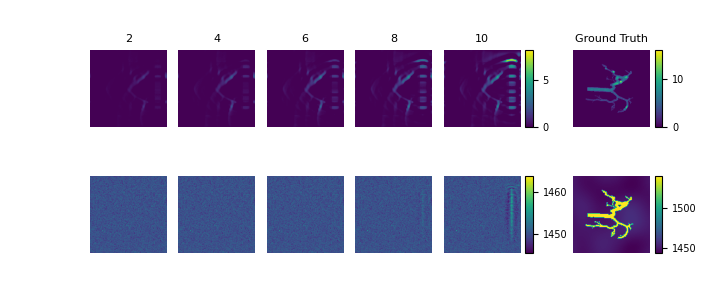

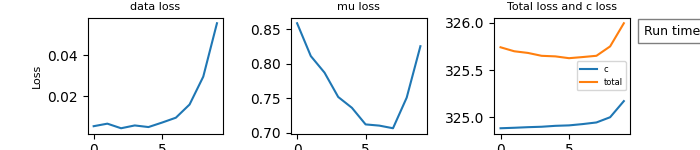

In [ ]:
(losses, recon), run_time = reconstruct(r.recon_step_ATrmu, lr=[.22, 4.], num_it=num_it)
figure = plot_recon(0, recon=recon, losses=losses, run_time=run_time, num_recon_images=num_recon_images, num_it=num_it)
figure.savefig(save_path+"recon_step_ATrmu.pdf", bbox_inches='tight', format='pdf', dpi=dpi)
fig_loss = plot_losses(losses, run_time)
fig_loss.savefig(save_path+"recon_step_ATrmu_losses.pdf", bbox_inches='tight', format='pdf', dpi=dpi//2)

File 0 
Iter	Loss_data	Loss_mu		Loss_c		Loss_sum_mu_c
0	0.005371	0.892759	324.882812	325.775574
2	0.006181	0.607209	327.552948	328.160156
4	0.002231	0.529342	330.491821	331.021149
6	0.000962	0.499690	333.029114	333.528809
9	0.001117	0.475805	335.814056	336.289856
Finished 'reconstruct' in 5.8618 secs


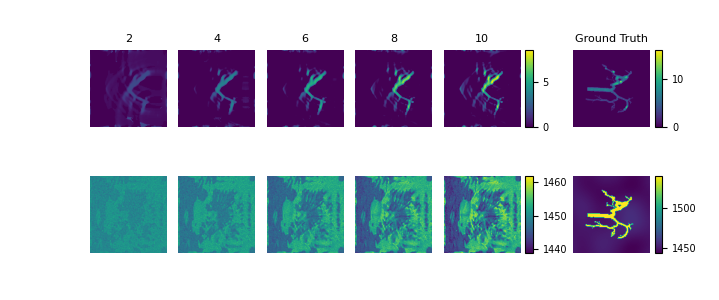

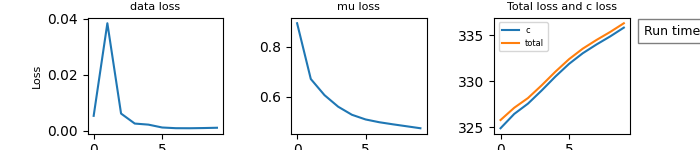

In [ ]:
(losses, recon), run_time = reconstruct(r.recon_step_ATrmu_opt1, lr=1., num_it=num_it)
figure = plot_recon(0, recon, losses, run_time, num_recon_images, num_it)
figure.savefig(save_path+"recon_step_ATrmu_opt1.pdf", bbox_inches='tight', format='pdf', dpi=dpi)
fig_loss = plot_losses(losses, run_time)
fig_loss.savefig(save_path+"recon_step_ATrmu_opt1_losses.pdf", bbox_inches='tight', format='pdf', dpi=dpi//2)

File 0 
Iter	Loss_data	Loss_mu		Loss_c		Loss_sum_mu_c
0	0.005371	0.873843	324.882812	325.756653
2	0.006551	0.870696	1490642944.000000	1490642944.000000
4	nan	nan	nan	nan
6	nan	nan	nan	nan
9	nan	nan	nan	nan
Finished 'reconstruct' in 7.2885 secs


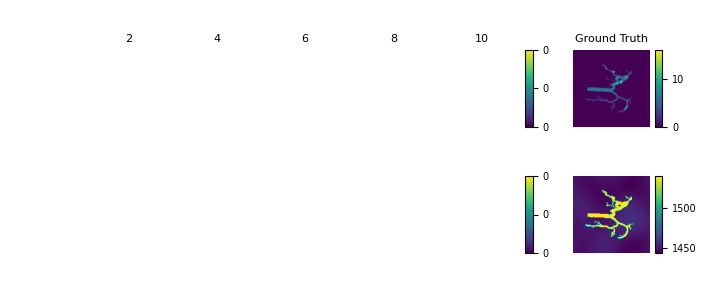

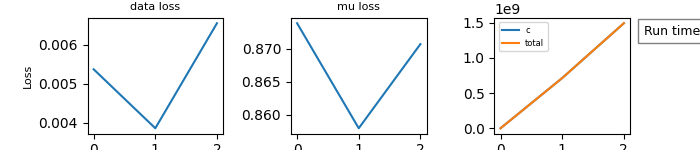

In [ ]:
(losses, recon), run_time = reconstruct(r.recon_step_ATrP0, lr=[.22, 100000000.], num_it=num_it)
figure = plot_recon(0, recon=recon, losses=losses, run_time=run_time, num_recon_images=num_recon_images, num_it=num_it)
figure.savefig(save_path+"recon_step_ATrP0.pdf", bbox_inches='tight', format='pdf', dpi=dpi)
fig_loss = plot_losses(losses, run_time)
fig_loss.savefig(save_path+"recon_step_ATrP0_losses.pdf", bbox_inches='tight', format='pdf', dpi=dpi//2)

File 0 
Iter	Loss_data	Loss_mu		Loss_c		Loss_sum_mu_c
0	0.005371	0.866183	324.882812	325.748993
2	0.007010	0.758069	318.791901	319.549957
4	0.003163	0.751008	315.533875	316.284882
6	0.001049	0.728771	314.340515	315.069275
9	0.000862	0.703867	314.093079	314.796936
Finished 'reconstruct' in 5.9670 secs


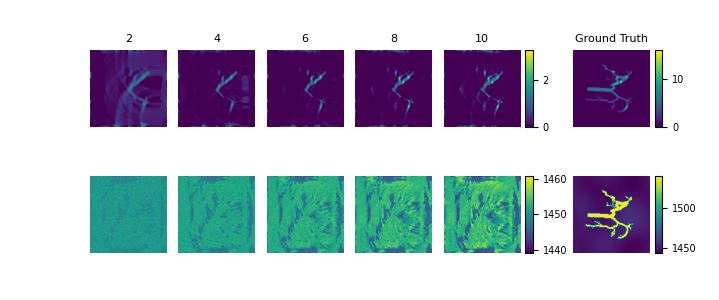

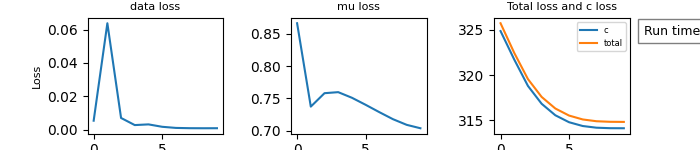

In [ ]:
(losses, recon), run_time = reconstruct(r.recon_step_ATrP0_opt1, lr=1., num_it=num_it)
figure = plot_recon(0, recon, losses, run_time, num_recon_images, num_it)
figure.savefig(save_path+"recon_step_ATrP0_opt1.pdf", bbox_inches='tight', format='pdf', dpi=dpi)
fig_loss = plot_losses(losses, run_time)
fig_loss.savefig(save_path+"recon_step_ATrP0_opt1_losses.pdf", bbox_inches='tight', format='pdf', dpi=dpi//2)

File 0 
Iter	Loss_data	Loss_mu		Loss_c		Loss_sum_mu_c
0	0.005371	12.698853	324.882812	337.581665
2	0.032683	12.547089	321.431335	333.978424
4	0.039662	12.734702	319.599854	332.334564
6	0.042698	13.055669	320.066711	333.122375
9	0.065200	10.277832	321.961853	332.239685
Finished 'reconstruct' in 5.9114 secs


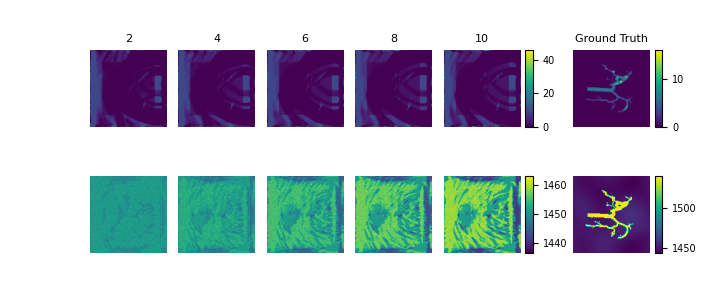

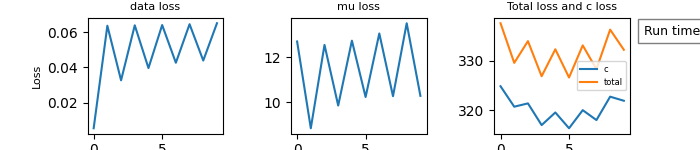

In [ ]:
(losses, recon), run_time = reconstruct(r.recon_step_ATrP0_opt2, lr=[1.,1.], num_it=num_it)
figure = plot_recon(0, recon, losses, run_time, num_recon_images, num_it)
figure.savefig(save_path+"recon_step_ATrP0_opt2.pdf", bbox_inches='tight', format='pdf', dpi=dpi)
fig_loss = plot_losses(losses, run_time)
fig_loss.savefig(save_path+"recon_step_ATrP0_opt2_losses.pdf", bbox_inches='tight', format='pdf', dpi=dpi//2)

In [ ]:
N = (128,128)
DX = 0.1e-3
domain = Domain(N, DX)

cf = FourierSeries(c, domain)

cf.params

Array([[[1450.    ],
        [1449.7808],
        [1449.5624],
        ...,
        [1449.3452],
        [1449.5646],
        [1449.7826]],

       [[1449.9744],
        [1449.7551],
        [1449.5367],
        ...,
        [1449.3042],
        [1449.5237],
        [1449.7418]],

       [[1449.95  ],
        [1449.7307],
        [1449.5125],
        ...,
        [1449.2621],
        [1449.4816],
        [1449.6996]],

       ...,

       [[1450.0906],
        [1449.8728],
        [1449.6578],
        ...,
        [1449.0603],
        [1449.2269],
        [1449.3893]],

       [[1450.0623],
        [1449.8441],
        [1449.6289],
        ...,
        [1449.207 ],
        [1449.3741],
        [1449.5367]],

       [[1450.0316],
        [1449.8135],
        [1449.5981],
        ...,
        [1449.3572],
        [1449.5245],
        [1449.6874]]], dtype=float32)

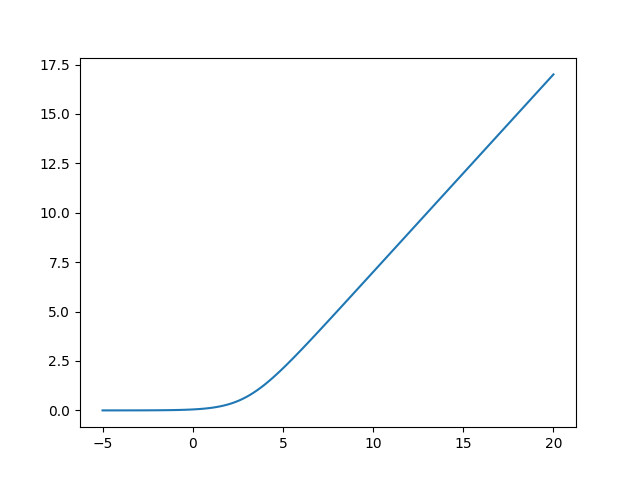

In [ ]:
xs = jnp.linspace(-5, 20, 120)
def get_mu(params):
    return compose(params-3)(nn.softplus)
plt.figure()
plt.plot(xs, get_mu(xs))

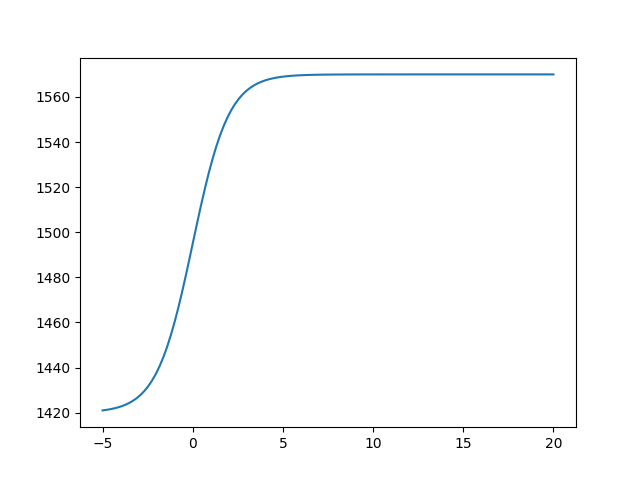

In [ ]:
def get_sound_speed(params):
    return 1420.0 + 150.0*compose(params)(nn.sigmoid)
plt.figure()
plt.plot(xs,get_sound_speed(xs))
# plt.plot(xs,1410 + 150 * compose(xs)(nn.sigmoid))

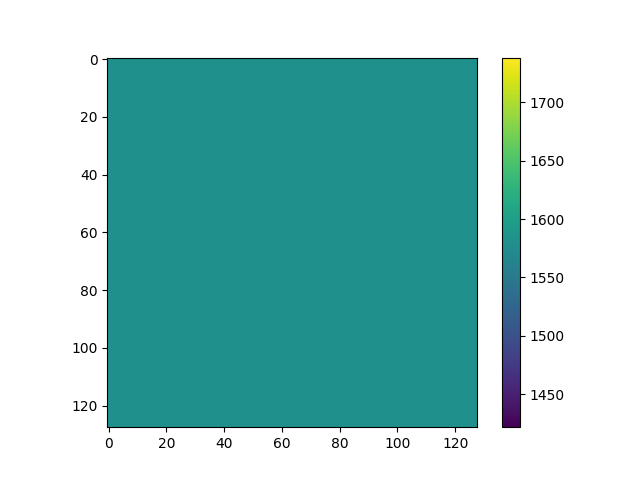

In [ ]:
cr=recon['c_rs'][1]
plt.figure()
# cr = compose(cr)(nn.sigmoid)
plt.imshow(1430 + 150 * compose(cr)(nn.sigmoid))
plt.colorbar()


---